In [1]:
%run ../../../global-tools/start.py

# import your local functions
sys.path.insert(1, '../../code/')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


In [2]:
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(35, 120) # bounds inclusive
time_slice = slice('1979-01-01','2020-05-31')

In [3]:
# get data from tigress
path = '../../../../shared_data/wind_NCEP_Reanalysis_2/concatenated/'
infn = 'uwnd.10m.mon.mean.nc'

ds_U = xr.open_dataset(path + infn)
ds_U

<xarray.Dataset>
Dimensions:    (lat: 94, level: 1, lon: 192, nbnds: 2, time: 503)
Coordinates:
  * level      (level) float32 10.0
  * lat        (lat) float32 88.542 86.6531 84.7532 ... -86.6531 -88.542
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 354.375 356.25 358.125
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    uwnd       (time, level, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.

In [4]:
# get data from tigress
path = '../../../../shared_data/wind_NCEP_Reanalysis_2/concatenated/'
infn = 'vwnd.10m.mon.mean.nc'

ds_V = xr.open_dataset(path + infn)
ds_V

<xarray.Dataset>
Dimensions:    (lat: 94, level: 1, lon: 192, nbnds: 2, time: 503)
Coordinates:
  * level      (level) float32 10.0
  * lat        (lat) float32 88.542 86.6531 84.7532 ... -86.6531 -88.542
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 354.375 356.25 358.125
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    vwnd       (time, level, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.

In [5]:
# convert to xarray dataset
ds=xr.Dataset(coords={'lon': ds_U.lon,
                    'lat': np.flipud(ds_U.lat),
                    'time': ds_U.time})

# add variables to dataset

ds["uwnd"]=(['time','lat', 'lon'],  ds_U.uwnd[:,0,::-1,:]) # flips the lat variables
ds["vwnd"]=(['time','lat', 'lon'],  ds_V.vwnd[:,0,::-1,:])

#subset indian ocean
ds = ds.sel(lat=lat_slice,lon=lon_slice, time = time_slice)


# wind stress

# air density
p_air = 1.225 # kg/m^3
p_sea = 1025 # kg/m^3

xx,yy = np.meshgrid(ds.lon,ds.lat)

f = coriolis_par(yy)

n = len(ds.time)
m = len(ds.lat)
p = len(ds.lon)

Wnd_sp = np.full(ds.uwnd.shape,np.nan)
curl_tau = np.full(ds.uwnd.shape,np.nan)
W_Ek = np.full(ds.uwnd.shape,np.nan)
tau_x = np.full(ds.uwnd.shape,np.nan)
tau_y = np.full(ds.uwnd.shape,np.nan)

for tt in tqdm(range(len(ds.time))):
    tmpu = ds.uwnd[tt,:,:]
    tmpv = ds.vwnd[tt,:,:]

    # define wind speed
    W = np.array(np.sqrt(np.power(tmpu,2) + np.power(tmpv,2)))
    Wnd_sp[tt,:,:] = W

    # define drag coeficient matrix 
    C_d = np.full(xx.shape,np.nan)
    C_d[W < 11] = 0.0012
    C_d[W >= 11] = 0.00049 + W[W >= 11]*0.000065

    # calculate wind stress
    tau_x[tt,:,:] = p_air * C_d * W * tmpu
    tau_y[tt,:,:] = p_air * C_d * W * tmpv

    # find wind stress curl
    curl_tau[tt,:,:],_,_ = latlon_2D_vorticity(tau_x[tt,:,:],tau_y[tt,:,:],yy,xx)
    W_Ek[tt,:,:] = curl_tau[tt,:,:]/(p_sea * f)

100%|██████████| 497/497 [02:27<00:00,  3.37it/s]


In [6]:
# add variables to dataset

ds["Wnd_sp"]=xr.DataArray(Wnd_sp,dims = ['time','lat','lon'],
                     coords =[ds.time,ds.lat,ds.lon])
ds["curl_tau"]=xr.DataArray(curl_tau,dims = ['time','lat','lon'],
                     coords =[ds.time,ds.lat,ds.lon])
ds["tau_x"]=xr.DataArray(tau_x,dims = ['time','lat','lon'],
                     coords =[ds.time,ds.lat,ds.lon])
ds["tau_y"]=xr.DataArray(tau_y,dims = ['time','lat','lon'],
                     coords =[ds.time,ds.lat,ds.lon])
ds["W_Ek"]=xr.DataArray(W_Ek,dims = ['time','lat','lon'],
                     coords =[ds.time,ds.lat,ds.lon])

In [7]:
# find climatologies/anomalies
uwnd_seas_clim = seasonal_clim(ds.uwnd)
uwnd_mon_clim = monthly_clim(ds.uwnd)

vwnd_seas_clim = seasonal_clim(ds.vwnd)
vwnd_mon_clim = monthly_clim(ds.vwnd)

Wnd_sp_seas_clim = seasonal_clim(ds.Wnd_sp)
Wnd_sp_mon_clim = monthly_clim(ds.Wnd_sp)

curl_tau_seas_clim = seasonal_clim(ds.curl_tau)
curl_tau_mon_clim = monthly_clim(ds.curl_tau)

tau_x_seas_clim = seasonal_clim(ds.tau_x)
tau_x_mon_clim = monthly_clim(ds.tau_x)

tau_y_seas_clim = seasonal_clim(ds.tau_y)
tau_y_mon_clim = monthly_clim(ds.tau_y)

W_Ek_seas_clim = seasonal_clim(ds.W_Ek)
W_Ek_mon_clim = monthly_clim(ds.W_Ek)

# add to dataset
ds["uwnd_seas_clim"]=xr.DataArray(uwnd_seas_clim,dims = ['season','lat','lon'],
                     coords =[uwnd_seas_clim.season,ds.lat,ds.lon])
ds["uwnd_mon_clim"]=xr.DataArray(uwnd_mon_clim,dims = ['month','lat','lon'],
                     coords =[uwnd_mon_clim.month,ds.lat,ds.lon])

ds["vwnd_seas_clim"]=xr.DataArray(vwnd_seas_clim,dims = ['season','lat','lon'],
                     coords =[vwnd_seas_clim.season,ds.lat,ds.lon])
ds["vwnd_mon_clim"]=xr.DataArray(vwnd_mon_clim,dims = ['month','lat','lon'],
                     coords =[vwnd_mon_clim.month,ds.lat,ds.lon])

ds["Wnd_sp_seas_clim"]=xr.DataArray(Wnd_sp_seas_clim,dims = ['season','lat','lon'],
                     coords =[Wnd_sp_seas_clim.season,ds.lat,ds.lon])
ds["Wnd_sp_mon_clim"]=xr.DataArray(Wnd_sp_mon_clim,dims = ['month','lat','lon'],
                     coords =[Wnd_sp_mon_clim.month,ds.lat,ds.lon])

ds["curl_tau_seas_clim"]=xr.DataArray(curl_tau_seas_clim,dims = ['season','lat','lon'],
                     coords =[curl_tau_seas_clim.season,ds.lat,ds.lon])
ds["curl_tau_mon_clim"]=xr.DataArray(curl_tau_mon_clim,dims = ['month','lat','lon'],
                     coords =[curl_tau_mon_clim.month,ds.lat,ds.lon])

ds["tau_x_seas_clim"]=xr.DataArray(tau_x_seas_clim,dims = ['season','lat','lon'],
                     coords =[tau_x_seas_clim.season,ds.lat,ds.lon])
ds["tau_x_mon_clim"]=xr.DataArray(tau_x_mon_clim,dims = ['month','lat','lon'],
                     coords =[tau_x_mon_clim.month,ds.lat,ds.lon])

ds["tau_y_seas_clim"]=xr.DataArray(tau_y_seas_clim,dims = ['season','lat','lon'],
                     coords =[tau_y_seas_clim.season,ds.lat,ds.lon])
ds["tau_y_mon_clim"]=xr.DataArray(tau_y_mon_clim,dims = ['month','lat','lon'],
                     coords =[tau_y_mon_clim.month,ds.lat,ds.lon])

ds["W_Ek_seas_clim"]=xr.DataArray(W_Ek_seas_clim,dims = ['season','lat','lon'],
                     coords =[W_Ek_seas_clim.season,ds.lat,ds.lon])
ds["W_Ek_mon_clim"]=xr.DataArray(W_Ek_mon_clim,dims = ['month','lat','lon'],
                     coords =[W_Ek_mon_clim.month,ds.lat,ds.lon])

In [8]:
outfn = 'ncep_wind_processed.nc'
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds

<xarray.Dataset>
Dimensions:             (lat: 27, lon: 46, month: 12, season: 4, time: 497)
Coordinates:
  * lon                 (lon) float32 35.625 37.5 39.375 ... 118.125 120.0
  * lat                 (lat) float32 -19.9997 -18.095 ... 27.6186 29.5234
  * time                (time) datetime64[ns] 1979-01-01 ... 2020-05-01
  * season              (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    uwnd                (time, lat, lon) float32 -3.399994 ... -1.5340325
    vwnd                (time, lat, lon) float32 2.1799927 ... 1.3312091
    Wnd_sp              (time, lat, lon) float64 4.039 4.134 ... 1.381 2.031
    curl_tau            (time, lat, lon) float64 -4.489e-08 ... 1.903e-08
    tau_x               (time, lat, lon) float64 -0.02019 -0.01939 ... -0.00458
    tau_y               (time, lat, lon) float64 0.01294 0.01598 ... 0.003975
    W_Ek                (time, lat, lon) float64 8.783e-07 ... 2.585e-0

Text(0.5, 1.0, 'SON')

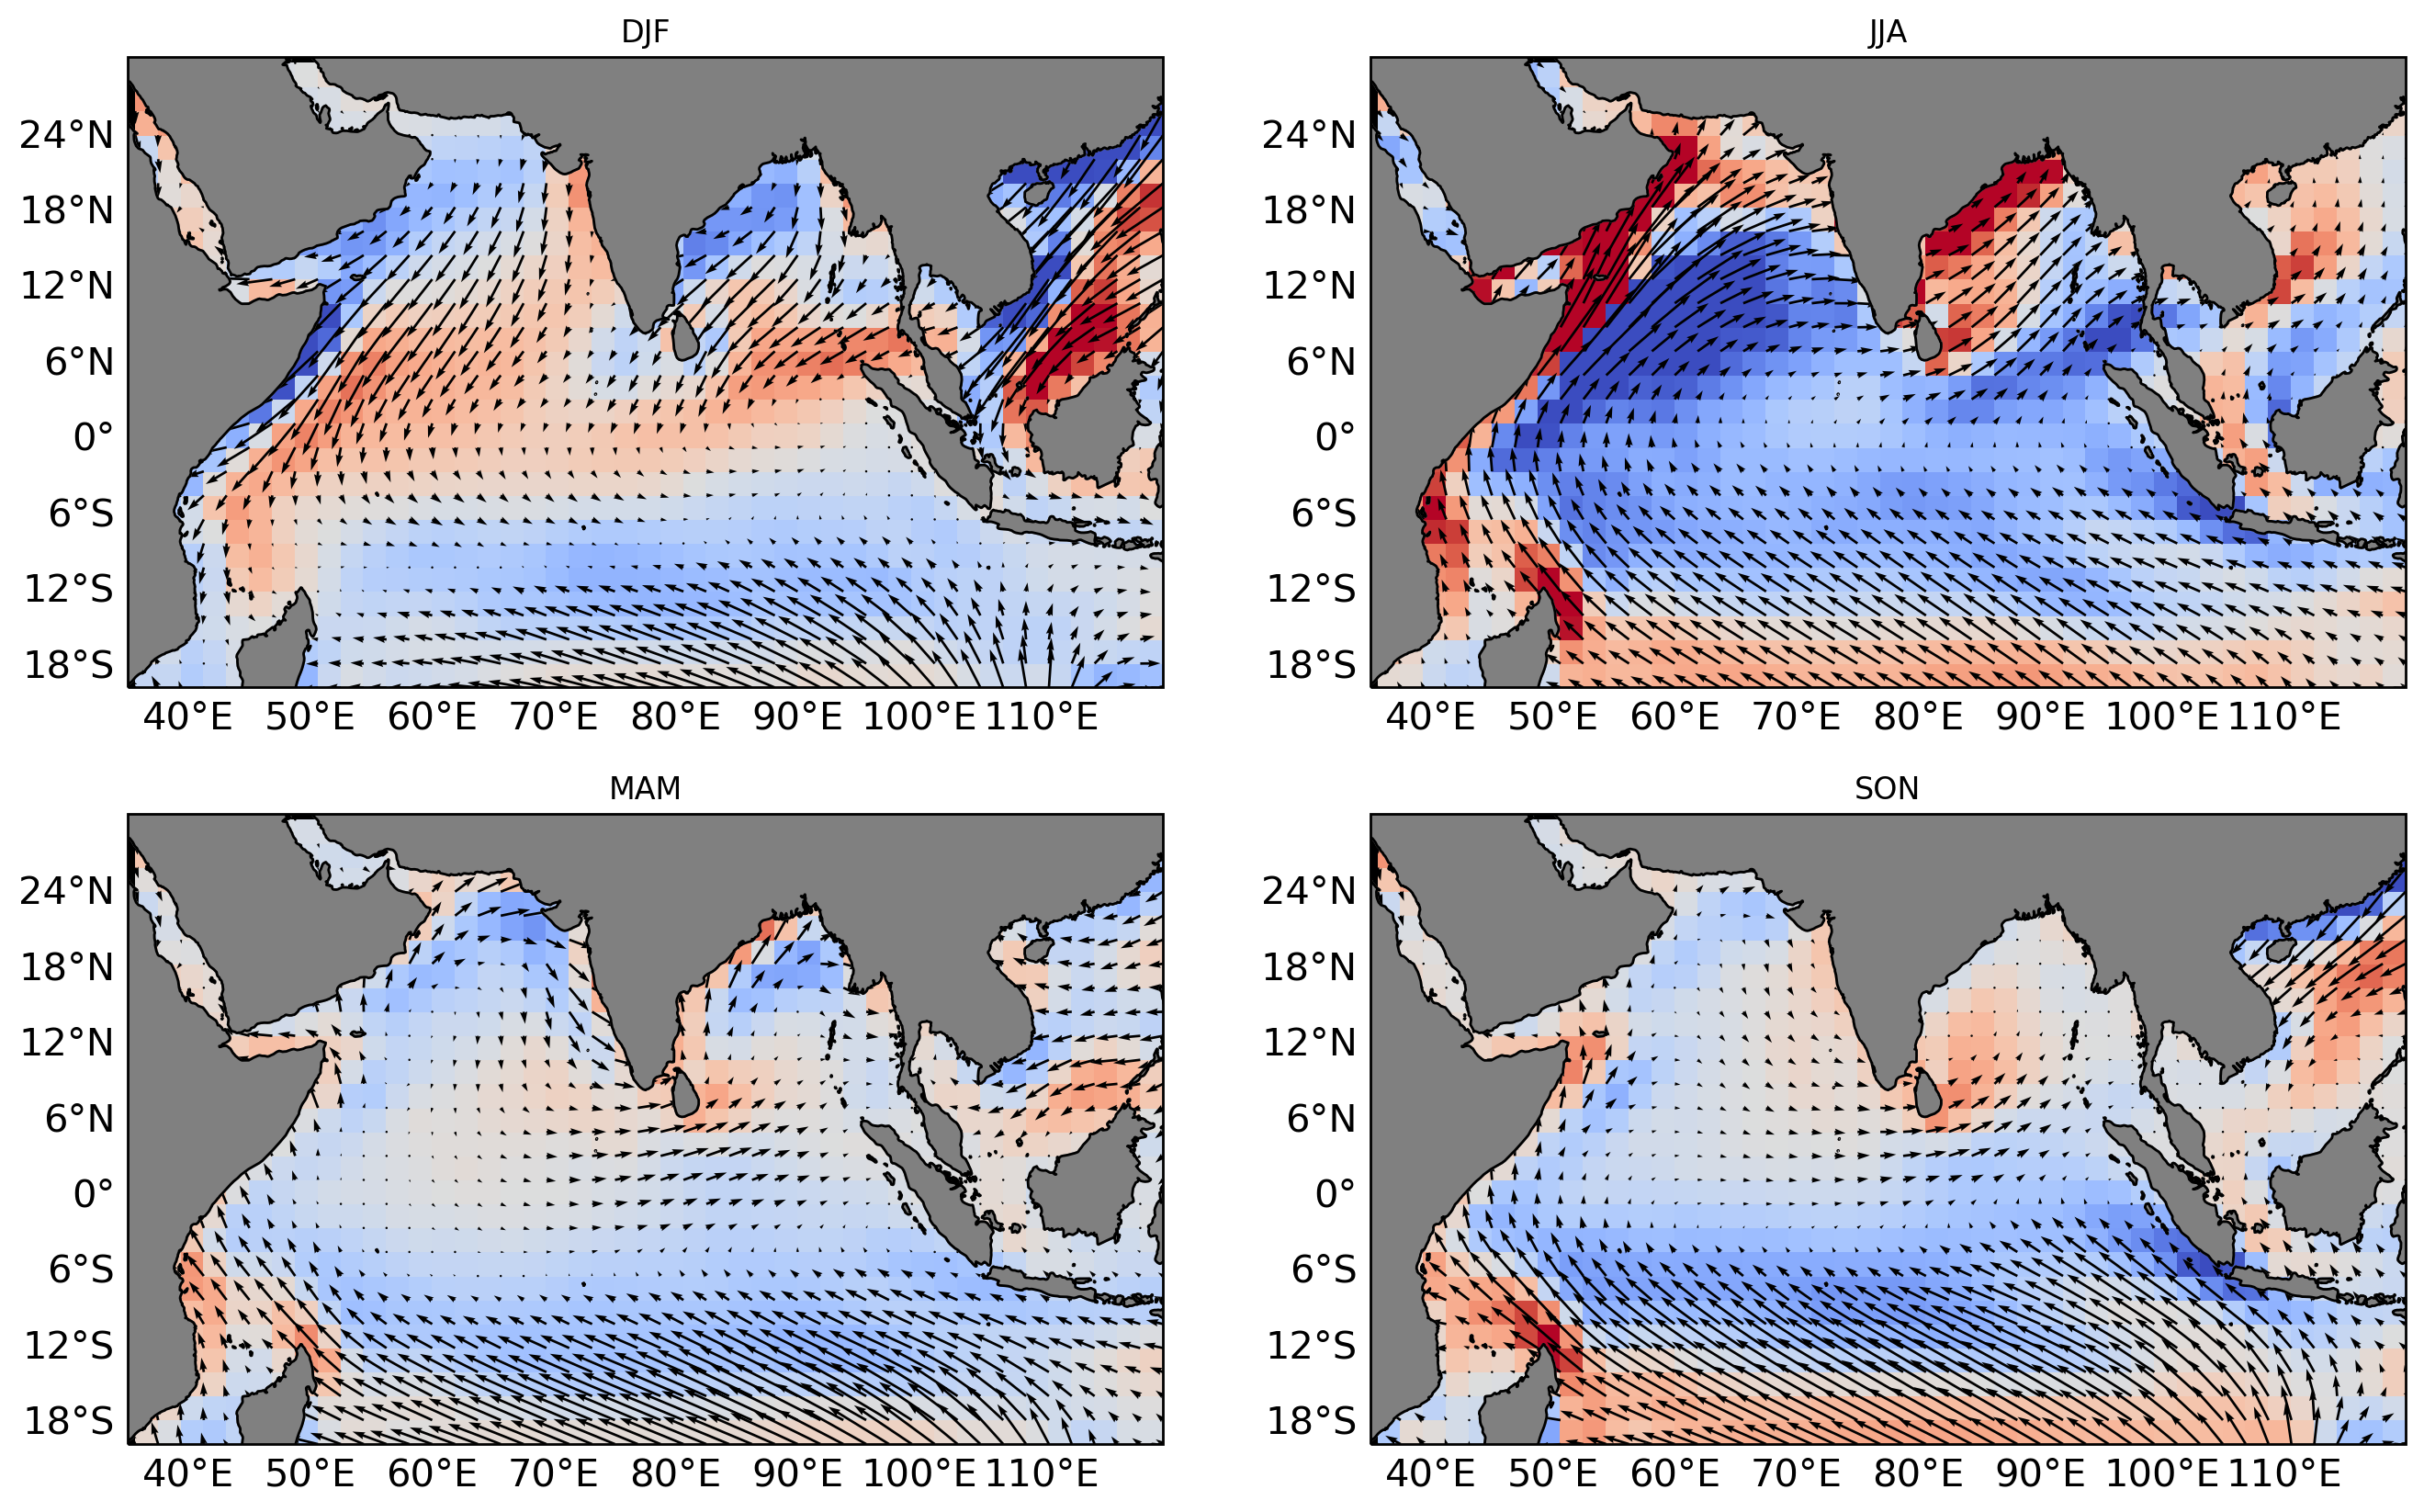

In [9]:

xx,yy = np.meshgrid(ds.lon,ds.lat)
cmin = -2e-7
cmax = 2e-7
fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})

ax = axes[0,0]
p = ax.pcolor(xx,yy,ds.curl_tau_seas_clim[0,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,ds.tau_x_seas_clim[0,:,:],ds.tau_y_seas_clim[0,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[0]))

ax = axes[0,1]
p = ax.pcolor(xx,yy,ds.curl_tau_seas_clim[1,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,ds.tau_x_seas_clim[1,:,:],ds.tau_y_seas_clim[1,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[1]))

ax = axes[1,0]
p = ax.pcolor(xx,yy,ds.curl_tau_seas_clim[2,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,ds.tau_x_seas_clim[2,:,:],ds.tau_y_seas_clim[2,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[2]))

ax = axes[1,1]
p = ax.pcolor(xx,yy,ds.curl_tau_seas_clim[3,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,ds.tau_x_seas_clim[3,:,:],ds.tau_y_seas_clim[3,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[3]))




Text(0.5, 1.0, 'SON')

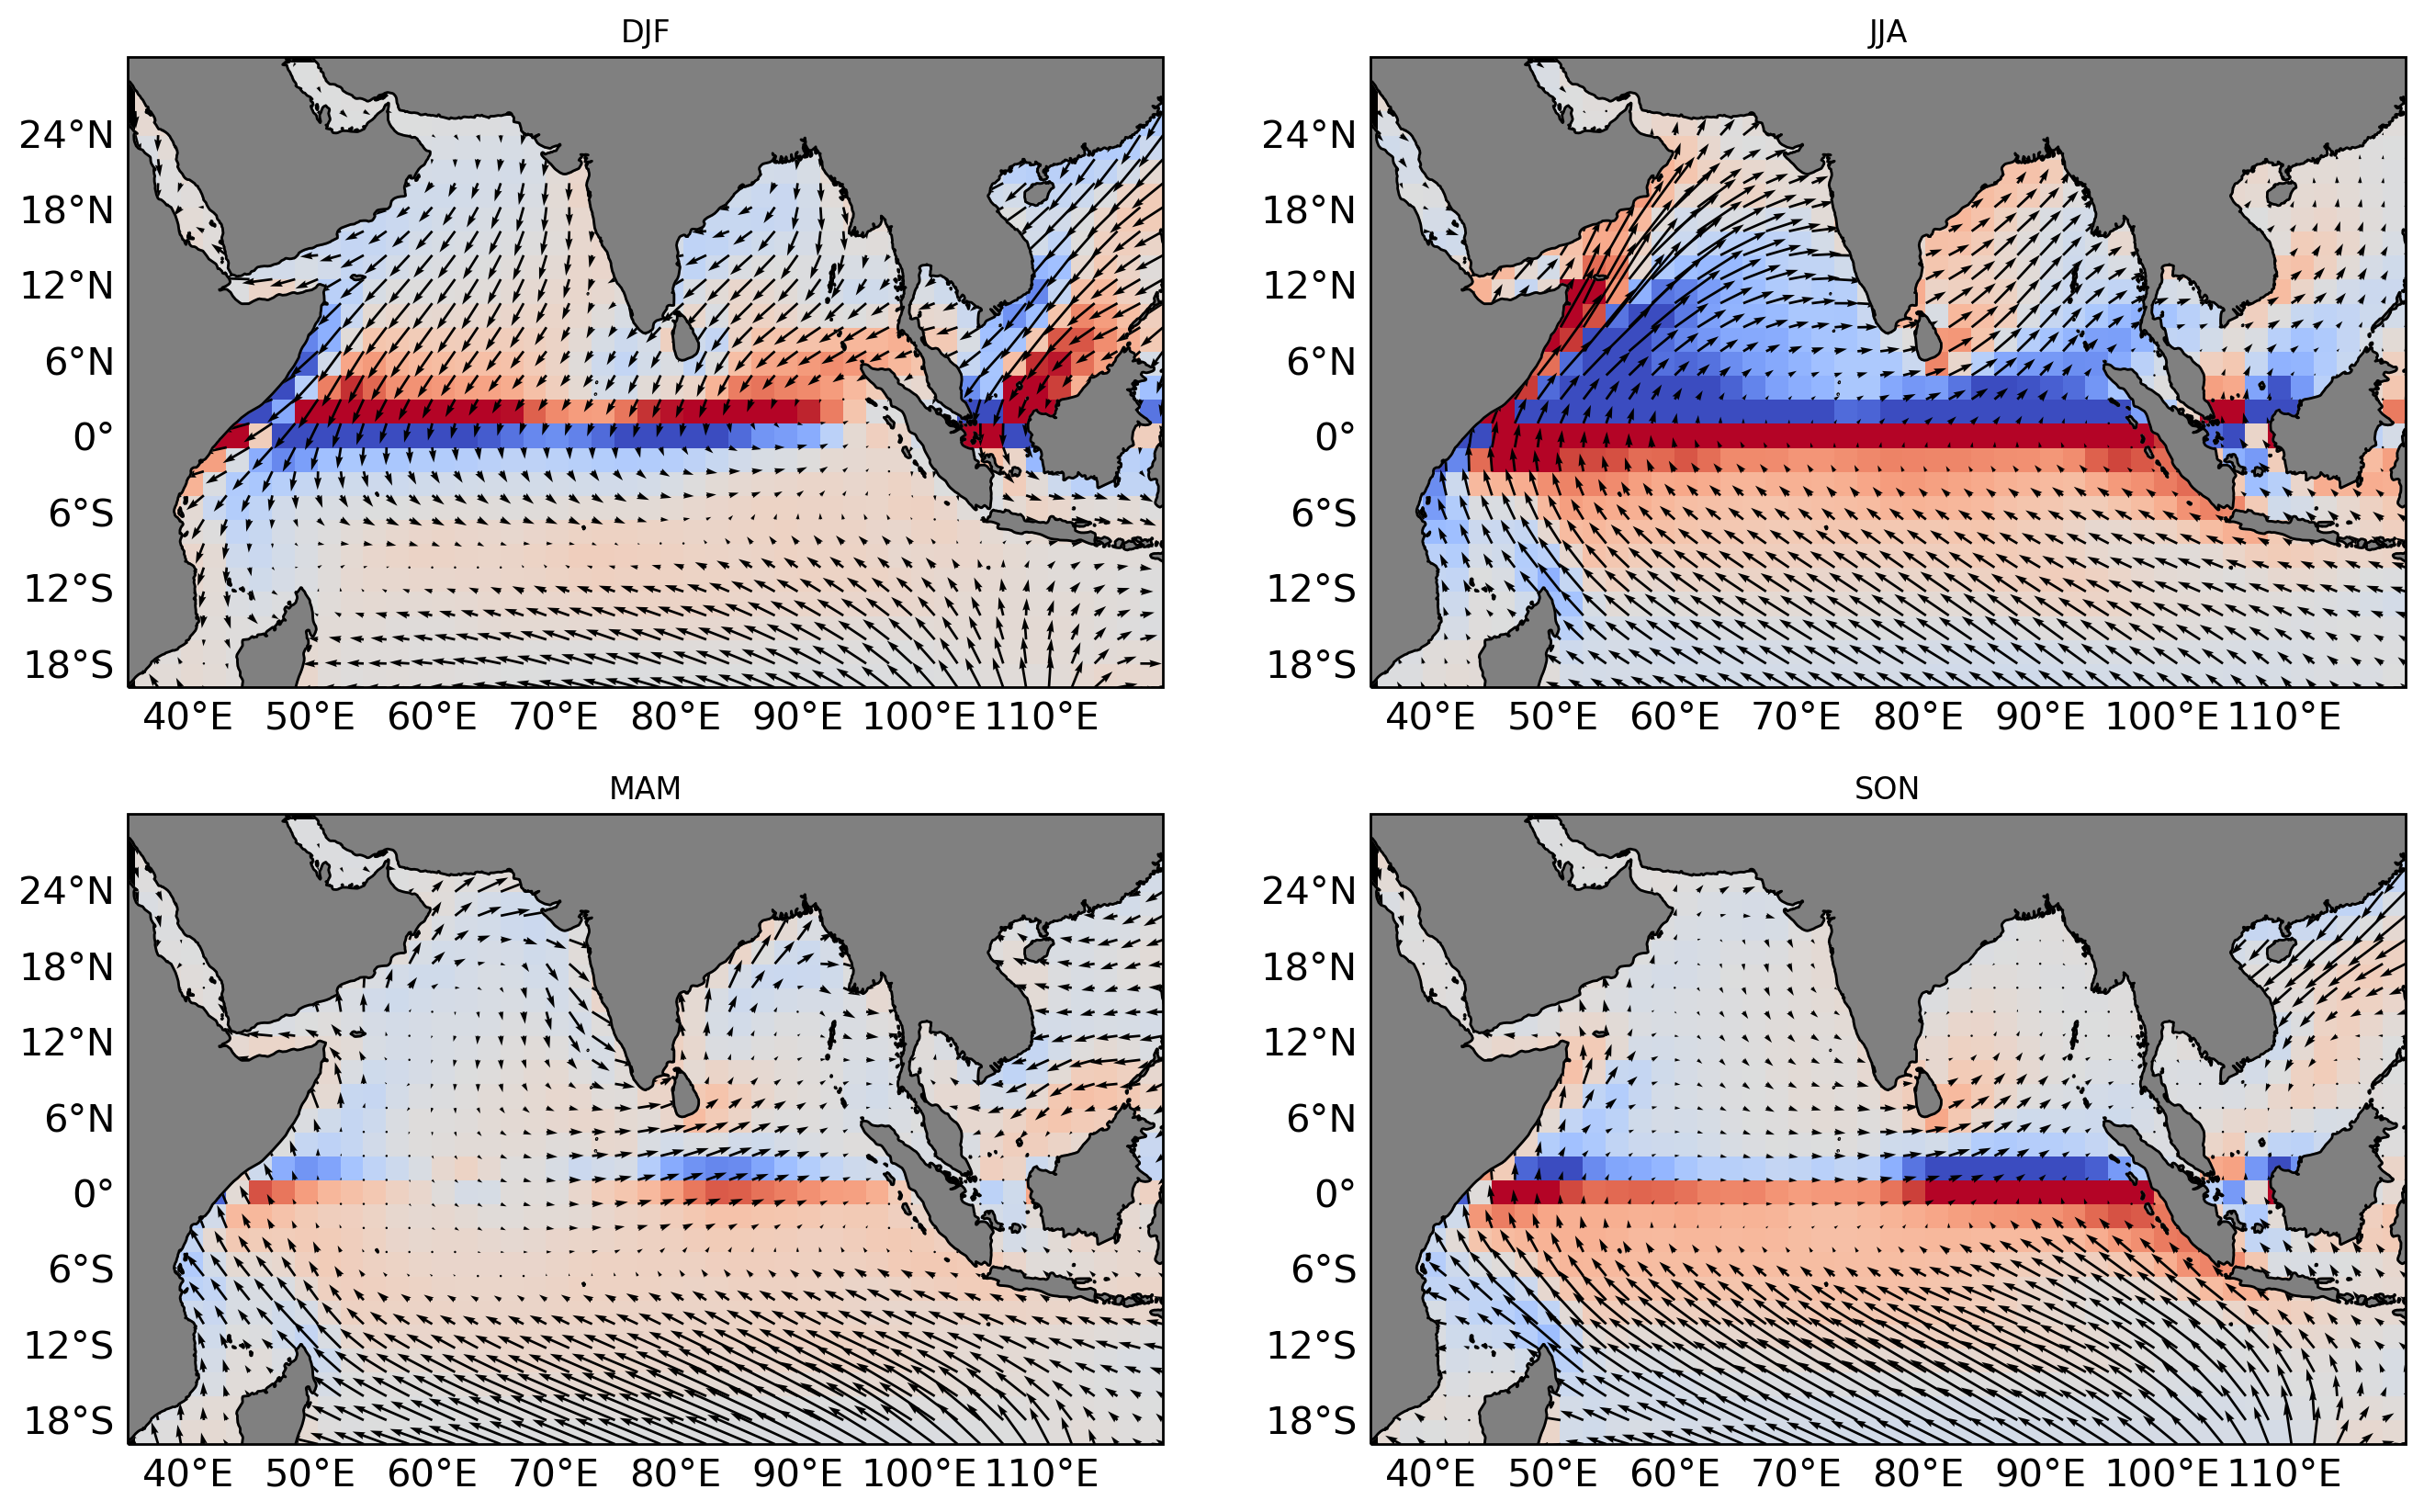

In [10]:
cmin = -2e-5
cmax = 2e-5
fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})

ax = axes[0,0]
p = ax.pcolor(xx,yy,ds.W_Ek_seas_clim[0,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,ds.uwnd_seas_clim[0,:,:],ds.vwnd_seas_clim[0,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[0]))

ax = axes[0,1]
p = ax.pcolor(xx,yy,W_Ek_seas_clim[1,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,tau_x_seas_clim[1,:,:],tau_y_seas_clim[1,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[1]))

ax = axes[1,0]
p = ax.pcolor(xx,yy,W_Ek_seas_clim[2,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,tau_x_seas_clim[2,:,:],tau_y_seas_clim[2,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[2]))

ax = axes[1,1]
p = ax.pcolor(xx,yy,W_Ek_seas_clim[3,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,tau_x_seas_clim[3,:,:],tau_y_seas_clim[3,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[3]))



